# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
import pickle
from sklearn.utils import shuffle
import random
import csv
import scipy.ndimage
from skimage.transform import resize
from skimage.transform import rotate

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
if tf.__version__.startswith('2'):
    import tensorflow.compat.v1 as tf
    from tensorflow.compat.v1.layers import flatten
    tf.disable_eager_execution()
    tf.disable_v2_behavior()
else:
    from tensorflow.contrib.layers import flatten
    

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
# Load pickled data
# Read training data, validation data, and testing data
training_file = './traffic-signs-data/train.p'
validation_file = './traffic-signs-data/valid.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
x_train, y_train = train['features'], train['labels']
x_valid, y_valid = valid['features'], valid['labels']
x_test, y_test = test['features'], test['labels']

In [3]:
sign_names = [''] * np.unique(train['labels']).shape[0]
with open('signnames.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            pass
        else:
            sign_names[int(row[0])] = row[1]
        line_count = line_count + 1

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [4]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

n_train = train['features'].shape[0]
n_validation = valid['features'].shape[0]
n_test = test['features'].shape[0]

image_shape = train['features'].shape[1:]

n_classes = np.unique(train['labels']).shape[0]

# print basic summary
print('Number of training examples =', n_train)
print('Number of valid examples =', n_validation)
print('Number of testing examples =', n_test)
print('Image data shape =', image_shape)
print('Range of data=({} - {})'.format(np.min(train['features']), np.max(train['features'])))
print('Number of classes =', n_classes)
print('All sign names =')

for index, sign_name in enumerate(sign_names):
    print('\t{}. {}'.format(index+1, sign_name))

Number of training examples = 34799
Number of valid examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Range of data=(0 - 255)
Number of classes = 43
All sign names =
	1. Speed limit (20km/h)
	2. Speed limit (30km/h)
	3. Speed limit (50km/h)
	4. Speed limit (60km/h)
	5. Speed limit (70km/h)
	6. Speed limit (80km/h)
	7. End of speed limit (80km/h)
	8. Speed limit (100km/h)
	9. Speed limit (120km/h)
	10. No passing
	11. No passing for vehicles over 3.5 metric tons
	12. Right-of-way at the next intersection
	13. Priority road
	14. Yield
	15. Stop
	16. No vehicles
	17. Vehicles over 3.5 metric tons prohibited
	18. No entry
	19. General caution
	20. Dangerous curve to the left
	21. Dangerous curve to the right
	22. Double curve
	23. Bumpy road
	24. Slippery road
	25. Road narrows on the right
	26. Road work
	27. Traffic signals
	28. Pedestrians
	29. Children crossing
	30. Bicycles crossing
	31. Beware of ice/snow
	32. Wild animals crossing
	33. End of all spee

### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

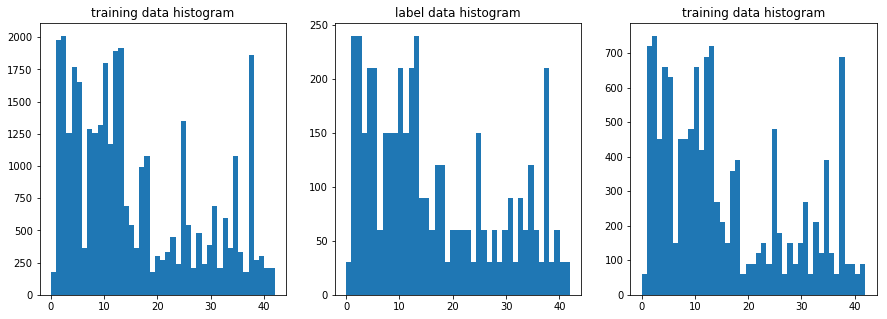

In [5]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
# Visualizations will be shown in the notebook.

fig = plt.figure(figsize=(15,5))

fig.add_subplot(1, 3, 1)
plt.hist(train['labels'], bins=n_classes)
plt.title("training data histogram")
fig.add_subplot(1, 3, 2)
plt.hist(valid['labels'], bins=n_classes)
plt.title("label data histogram")
fig.add_subplot(1, 3, 3)
plt.hist(test['labels'], bins=n_classes)
plt.title("training data histogram")
plt.show()

Class: Speed limit (20km/h), Training Sample Count: 180


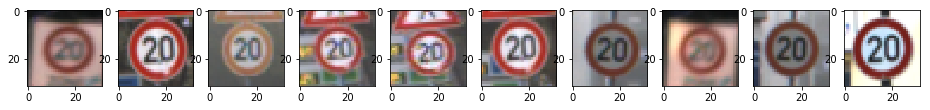

Class: Speed limit (30km/h), Training Sample Count: 1980


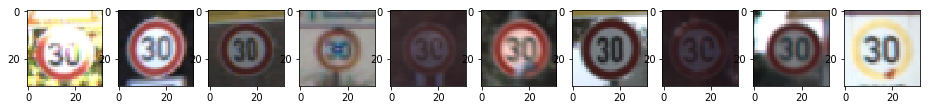

Class: Speed limit (50km/h), Training Sample Count: 2010


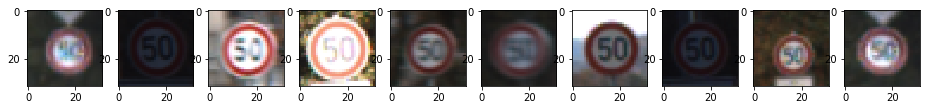

Class: Speed limit (60km/h), Training Sample Count: 1260


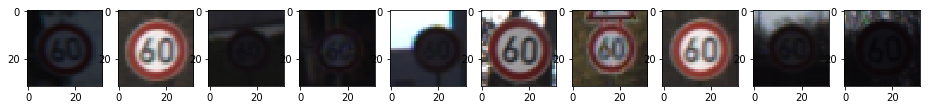

Class: Speed limit (70km/h), Training Sample Count: 1770


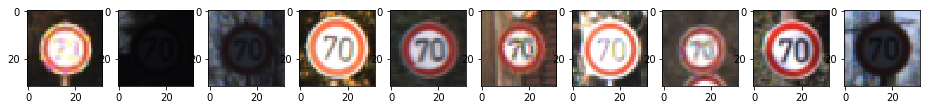

Class: Speed limit (80km/h), Training Sample Count: 1650


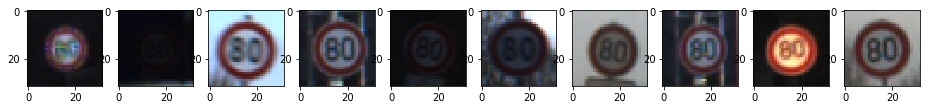

Class: End of speed limit (80km/h), Training Sample Count: 360


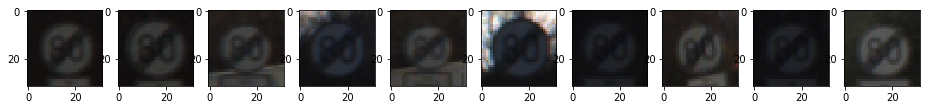

Class: Speed limit (100km/h), Training Sample Count: 1290


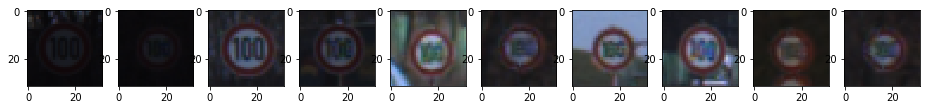

Class: Speed limit (120km/h), Training Sample Count: 1260


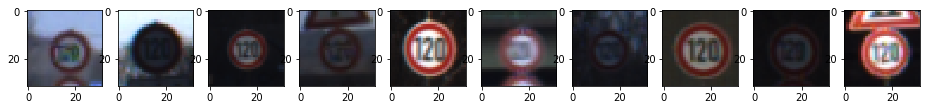

Class: No passing, Training Sample Count: 1320


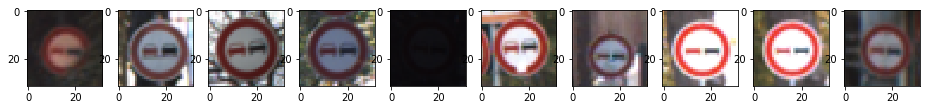

Class: No passing for vehicles over 3.5 metric tons, Training Sample Count: 1800


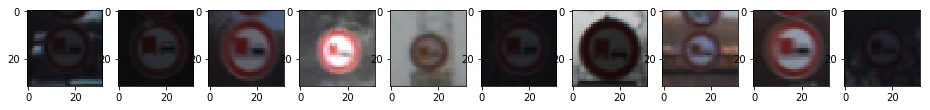

Class: Right-of-way at the next intersection, Training Sample Count: 1170


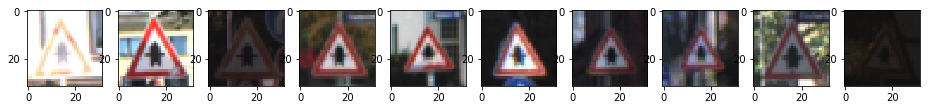

Class: Priority road, Training Sample Count: 1890


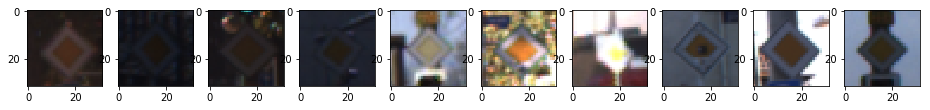

Class: Yield, Training Sample Count: 1920


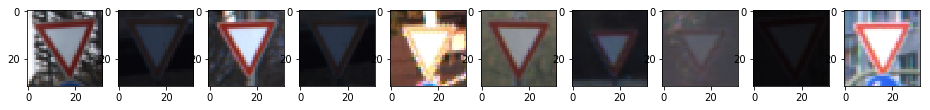

Class: Stop, Training Sample Count: 690


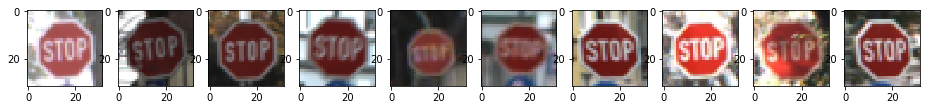

Class: No vehicles, Training Sample Count: 540


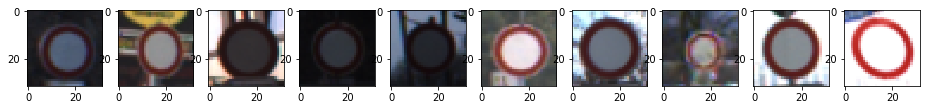

Class: Vehicles over 3.5 metric tons prohibited, Training Sample Count: 360


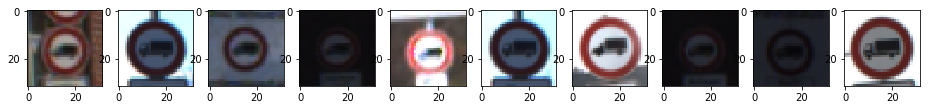

Class: No entry, Training Sample Count: 990


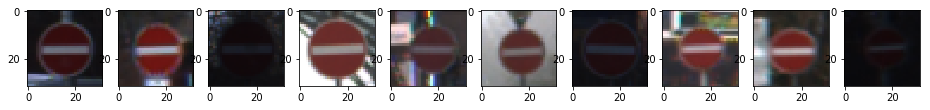

Class: General caution, Training Sample Count: 1080


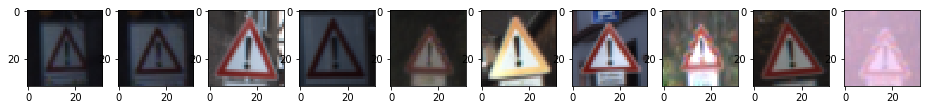

Class: Dangerous curve to the left, Training Sample Count: 180


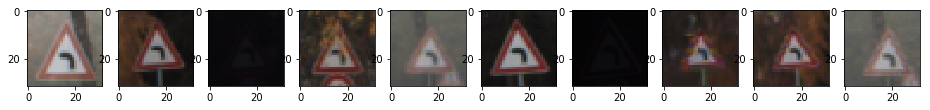

Class: Dangerous curve to the right, Training Sample Count: 300


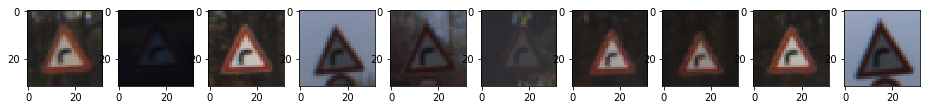

Class: Double curve, Training Sample Count: 270


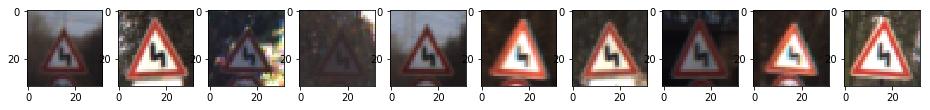

Class: Bumpy road, Training Sample Count: 330


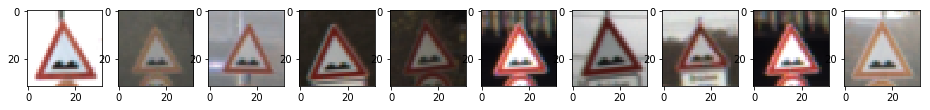

Class: Slippery road, Training Sample Count: 450


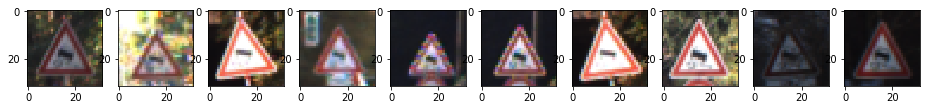

Class: Road narrows on the right, Training Sample Count: 240


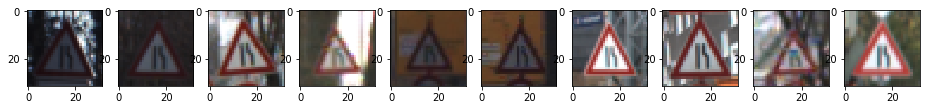

Class: Road work, Training Sample Count: 1350


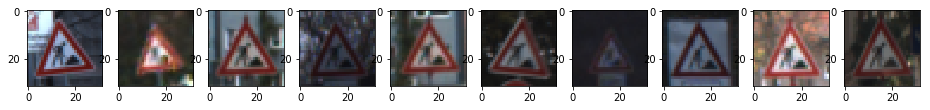

Class: Traffic signals, Training Sample Count: 540


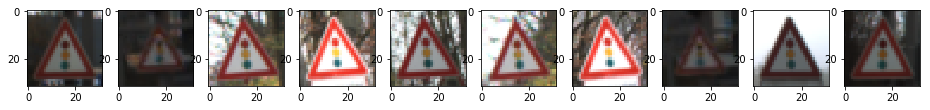

Class: Pedestrians, Training Sample Count: 210


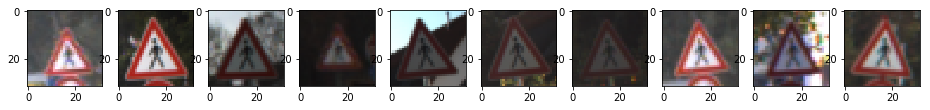

Class: Children crossing, Training Sample Count: 480


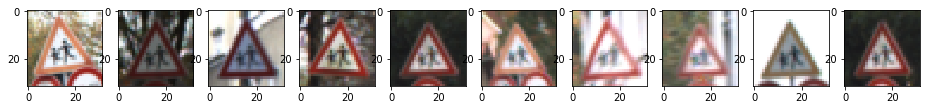

Class: Bicycles crossing, Training Sample Count: 240


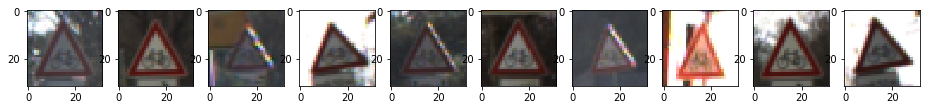

Class: Beware of ice/snow, Training Sample Count: 390


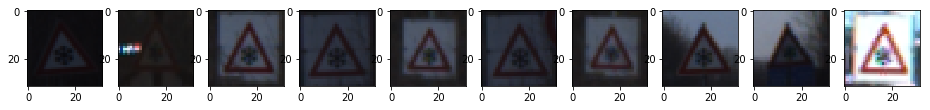

Class: Wild animals crossing, Training Sample Count: 690


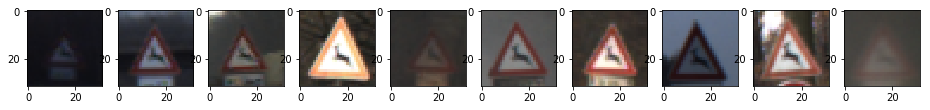

Class: End of all speed and passing limits, Training Sample Count: 210


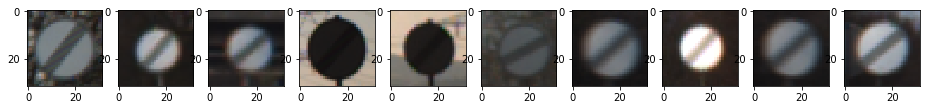

Class: Turn right ahead, Training Sample Count: 599


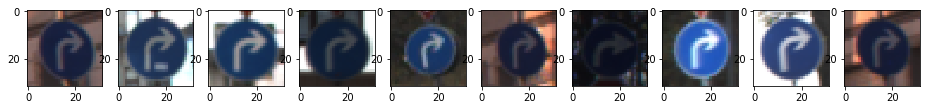

Class: Turn left ahead, Training Sample Count: 360


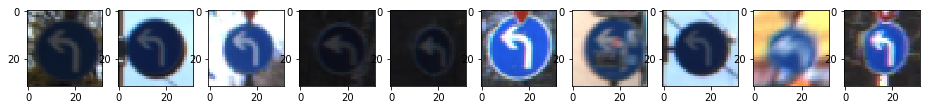

Class: Ahead only, Training Sample Count: 1080


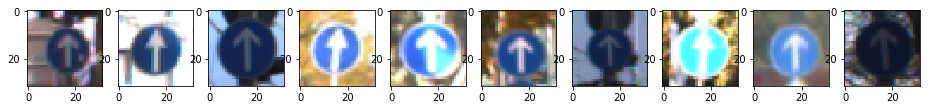

Class: Go straight or right, Training Sample Count: 330


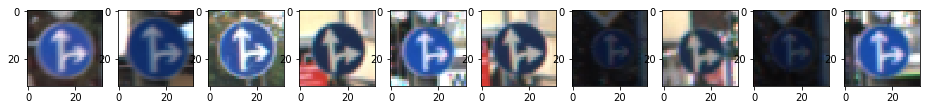

Class: Go straight or left, Training Sample Count: 180


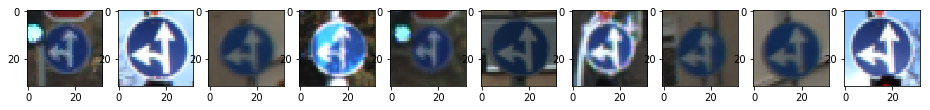

Class: Keep right, Training Sample Count: 1860


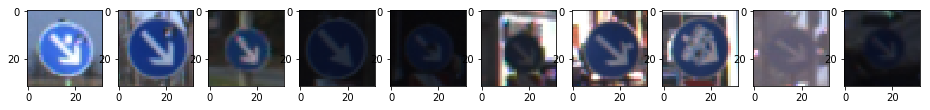

Class: Keep left, Training Sample Count: 270


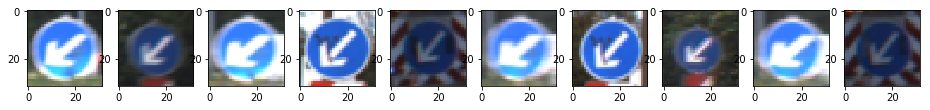

Class: Roundabout mandatory, Training Sample Count: 300


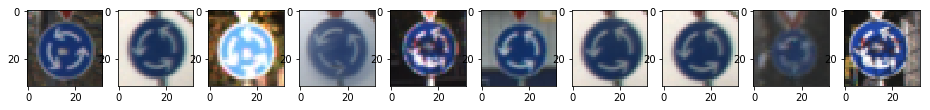

Class: End of no passing, Training Sample Count: 210


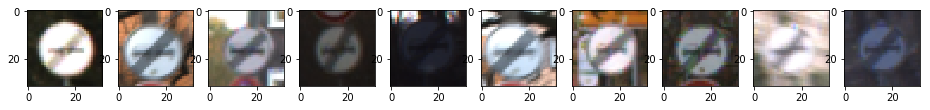

Class: End of no passing by vehicles over 3.5 metric tons, Training Sample Count: 210


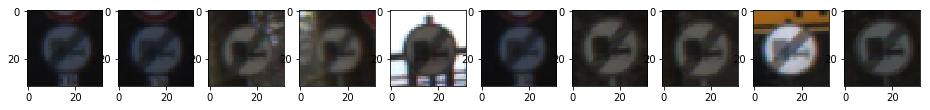

In [6]:
showImageCount = 10

x_display, y_display = shuffle(train['features'], train['labels'])
for sign_index in range(n_classes):
    x_train_single = x_display[y_display == sign_index]
    
    print('Class: {}, Training Sample Count: {}'.format(sign_names[sign_index], x_train_single.shape[0]))
    fig = plt.figure(figsize=(16, 160))
    for index in range(showImageCount):
        fig.add_subplot(1, 10, index + 1)
        plt.imshow(x_train_single[index])
    plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

### 1. Precessing for the whole training set
The training set is not well balanced for different classes. Therefore, duplicate the training samples for each class randomly so all classes have the same numbers of samples. Different sets of duplicates are computed for each epoch of the training. After the copying, many classes would have the same sample. To overcome this problem, we would perform image augmentation for each set.

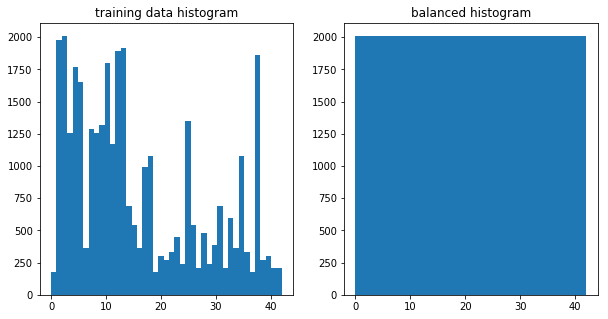

In [7]:
def balanceAndShuffleData(x_train, y_train, n_classes):
    trainHistogram = np.histogram(y_train, bins=n_classes)
    left = max(trainHistogram[0]) - trainHistogram[0]
    x_train, y_train = shuffle(x_train, y_train)
    for i in range(n_classes):
        remain = left[i]
        single_x_train = x_train[y_train == i]
        single_y_train = y_train[y_train == i]
        while remain > 0:
            start_index = 0
            end_index = len(single_y_train)
            if remain < len(single_y_train):
                end_index = remain
            x_train = np.vstack((x_train, single_x_train[start_index:end_index]))
            y_train = np.hstack((y_train, single_y_train[start_index:end_index]))
            remain = remain - len(single_y_train)
    x_train, y_train = shuffle(x_train, y_train)
    return x_train, y_train

[x_balanced_train, y_balanced_train] = balanceAndShuffleData(x_train, y_train, n_classes)

fig = plt.figure(figsize=(10,5))

fig.add_subplot(1, 2, 1)
plt.hist(y_train, bins=n_classes)
plt.title("training data histogram")

fig.add_subplot(1, 2, 2)
plt.hist(y_balanced_train, bins=n_classes) 
plt.title("balanced histogram") 
plt.show()

### 2. Precessing for each image (stage 1)
Convert to grayscale and make the data between 0 and 1. They are used for initial data.

In [8]:
# Convert to grayscale and make the data between 0 and 1
def convert_to_grayscale(x):
    x = x / 255.0
    x = 0.2126 * x[:,:,:,0] + 0.7152 * x[:,:,:,1] + 0.0722 * x[:,:,:,2]
    x = x[:,:,:, np.newaxis]
    return x

### 3. Precessing for each image (stage 2)
Normalize the result so that the 0 is mapped to the minimum value and 255 is mapped to the maximum value for each image. They are used right before the training or evaluation.

In [9]:
# Normalize the result so that the 0 is mapped to 
# the minimum value and 255 is mapped to the maximum value for each image
def normalize(x):
    shape = x.shape
    for imageIndex in range(shape[0]):
        min_value = np.min(x[imageIndex])
        max_value = np.max(x[imageIndex])
        x[imageIndex] = (x[imageIndex] - min_value) / (max_value - min_value)
    return x

Original


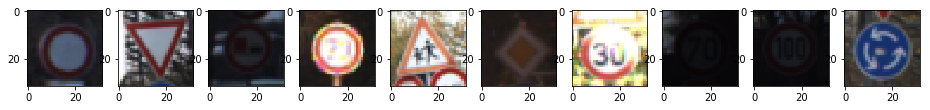

Grayscale (Stage 1)


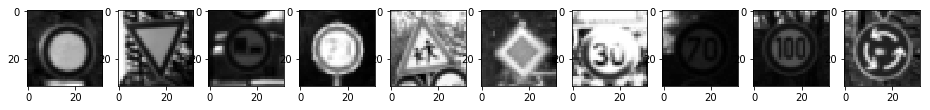

Normalized (Stage 2)


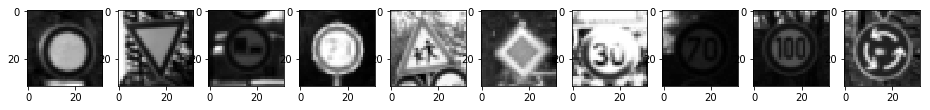

In [10]:
showImageCount = 10

x_grayscale_display = convert_to_grayscale(x_display)
x_normalized_display = normalize(x_grayscale_display)
print('Original')
fig = plt.figure(figsize=(16, 160))
for index in range(showImageCount):
    fig.add_subplot(1, 10, index + 1)
    plt.imshow(x_display[index])
plt.show()
print('Grayscale (Stage 1)')
fig = plt.figure(figsize=(16, 160))
for index in range(showImageCount):
    fig.add_subplot(1, 10, index + 1)
    plt.imshow(x_grayscale_display[index,:,:,0], cmap='gray')
plt.show()
print('Normalized (Stage 2)')
fig = plt.figure(figsize=(16, 160))
for index in range(showImageCount):
    fig.add_subplot(1, 10, index + 1)
    plt.imshow(x_normalized_display[index,:,:,0], cmap='gray')
plt.show()

### Augmentation
Image Augmentation using different ways:

1. Different lighting by adjusting gamma
2. Rotation
3. Scale
4. Translation

Image Augmentation would be performed after balancing the data. They would be performed for each epoch of the training.

### 1. Different lighting by adjusting gamma

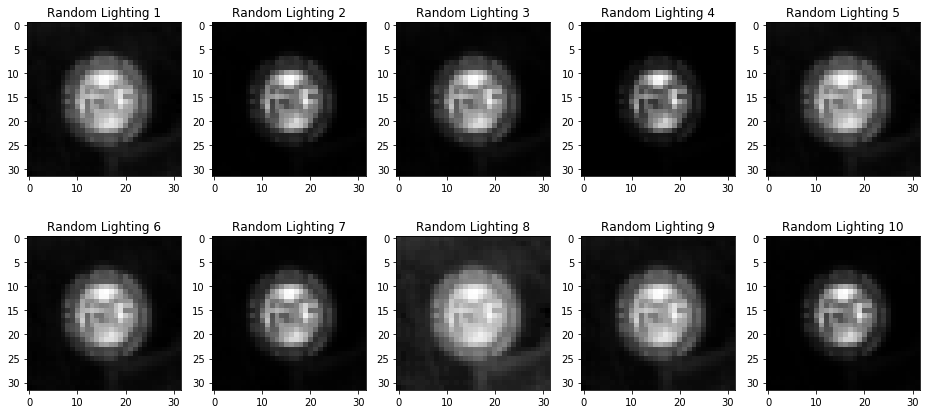

In [11]:
#Image augmentation using random lighting by apply random gamma
def AugmentingImageUsingGamma(image_batch, min_gamma, max_gamma):
    batch_size = image_batch.shape[0]
    for i in range(batch_size):
        
        image = image_batch[i,:,:,:].copy()
        
        gamma = random.random() * (max_gamma - min_gamma) + min_gamma
        image[:,:,:] = ((image[:,:,:]) ** gamma)
        
        image_batch[i,:,:,:] = image
        
    return image_batch

showImageCount = 10
index = 0
pltColCount = 5
loopPerRow = 5
target = 5
x_augmentation = x_grayscale_display[y_display == target]
x_augmentation = x_augmentation[0:1]
x_augmentation = np.tile(x_augmentation,(showImageCount,1,1,1))
x_augmentation = AugmentingImageUsingGamma(x_augmentation, 0.5, 2)
fig = plt.figure(figsize=(16, 18 * showImageCount / loopPerRow / pltColCount))
for i in range(0, showImageCount):
    fig.add_subplot(showImageCount // loopPerRow, pltColCount, i * pltColCount // loopPerRow + 1)
    plt.imshow(x_augmentation[i,:,:,0], cmap='gray')
    plt.title('Random Lighting {}'.format(i + 1))
plt.show()

### 2. Random Rotation

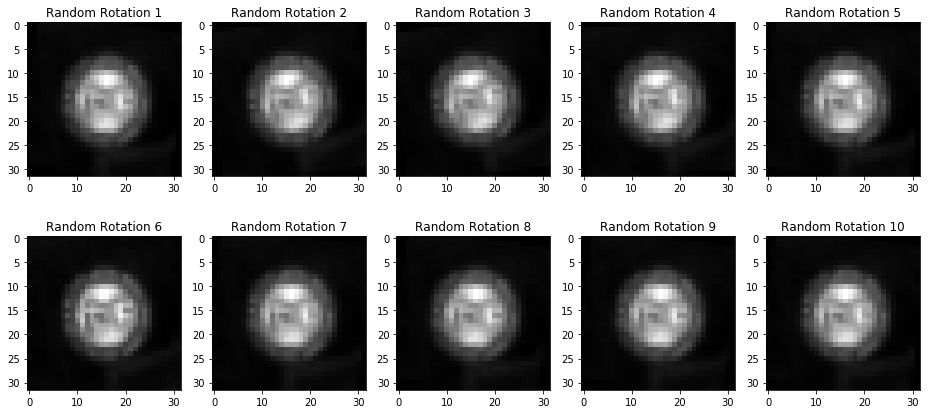

In [12]:
#Image augmentation using rotation
def AugmentingImageUsingRotation(image_batch, max_angle):
    batch_size = image_batch.shape[0]
    for i in range(batch_size):
        
        angle = random.random() * (2 * max_angle) - max_angle
        image = image_batch[i,:,:,:].copy()
        
        image = rotate(image, angle)
        
        image_batch[i,:,:,:] = image
        
    return image_batch

showImageCount = 10
index = 0
pltColCount = 5
loopPerRow = 5
target = 5
x_augmentation = x_grayscale_display[y_display == target]
x_augmentation = x_augmentation[0:1]
x_augmentation = np.tile(x_augmentation,(showImageCount,1,1,1))
x_augmentation = AugmentingImageUsingRotation(x_augmentation, 10)
fig = plt.figure(figsize=(16, 18 * showImageCount / loopPerRow / pltColCount))
for i in range(0, showImageCount):
    fig.add_subplot(showImageCount // loopPerRow, pltColCount, i * pltColCount // loopPerRow + 1)
    plt.imshow(x_augmentation[i,:,:,0], cmap='gray')
    plt.title('Random Rotation {}'.format(i + 1))
plt.show()

### 3. Random Scale

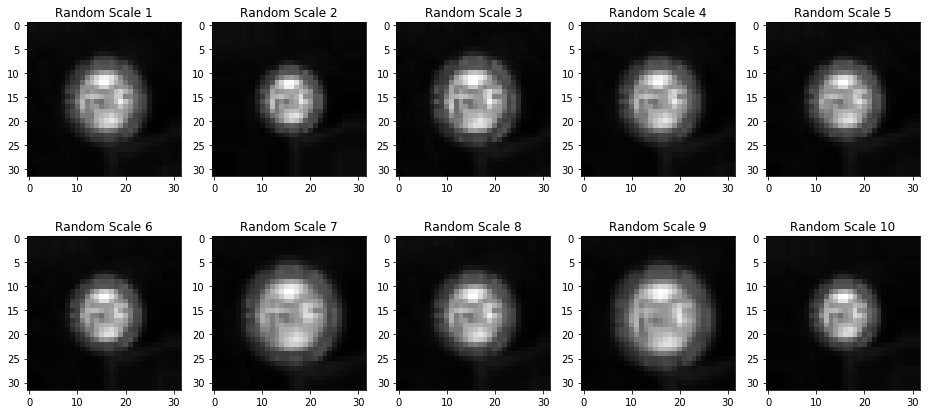

In [13]:
#Image augmentation using scale
def AugmentingImageUsingScale(image_batch, min_scale, max_scale):
    batch_size = image_batch.shape[0]
    for i in range(batch_size):
        
        scale = random.random() * (max_scale - min_scale) + min_scale
        image = image_batch[i,:,:,:].copy()
        
        image_shape = image.shape
        
        if scale >= 1:
            target_image_shape = image_shape
            target_x = int(target_image_shape[0] * scale)
            target_y = int(target_image_shape[1] * scale)
            image = resize(image, (target_x, target_y), anti_aliasing=True)
            x_start = int((target_x - image_shape[0]) / 2)
            y_start = int((target_y - image_shape[1]) / 2)
            image = image[x_start:x_start + target_image_shape[0],x_start:y_start + target_image_shape[0],:]
        else:
            target_image_shape = image_shape
            target_x = int(target_image_shape[0] / scale)
            target_y = int(target_image_shape[1] / scale)
            x_pad = int((target_x - image_shape[0]) / 2)
            y_pad = int((target_y - image_shape[1]) / 2)
            image = np.pad(image, ((x_pad, y_pad), (x_pad, y_pad), (0, 0)), 'edge')
            image = resize(image, (image_shape[0], image_shape[1]), anti_aliasing=True)
        
        
        image_batch[i,:,:,:] = image
        
    return image_batch

showImageCount = 10
index = 0
pltColCount = 5
loopPerRow = 5
target = 5
x_augmentation = x_grayscale_display[y_display == target]
x_augmentation = x_augmentation[0:1]
x_augmentation = np.tile(x_augmentation,(showImageCount,1,1,1))
x_augmentation = AugmentingImageUsingScale(x_augmentation, 0.7, 1.2)
fig = plt.figure(figsize=(16, 18 * showImageCount / loopPerRow / pltColCount))
for i in range(0, showImageCount):
    fig.add_subplot(showImageCount // loopPerRow, pltColCount, i * pltColCount // loopPerRow + 1)
    plt.imshow(x_augmentation[i,:,:,0], cmap='gray')
    plt.title('Random Scale {}'.format(i + 1))
plt.show()

### 4. Random Translation

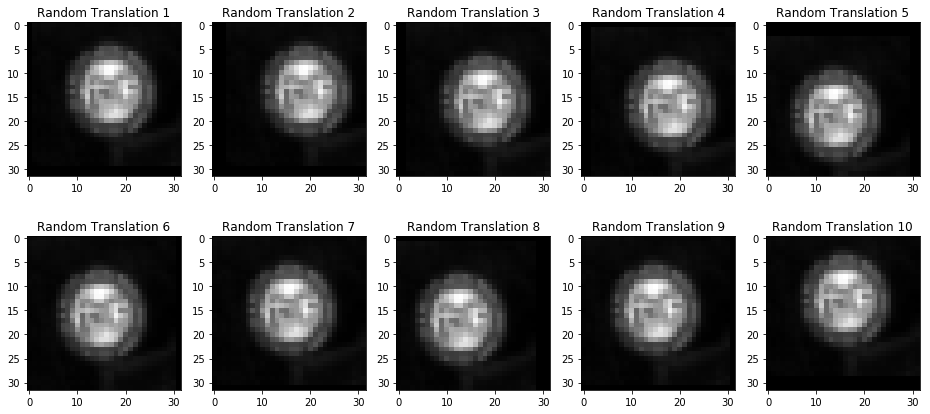

In [14]:
#Image augmentation using translation
def AugmentingImageUsingTranslation(image_batch, max_x_shift, max_y_shift):
    batch_size = image_batch.shape[0]
    for i in range(batch_size):
        x_shift = random.randint(-max_x_shift, max_x_shift)
        y_shift = random.randint(-max_y_shift, max_y_shift)
        
        image = image_batch[i,:,:,:].copy()
        
        if x_shift > 0:
            image[:, x_shift:,:] = image[:, :-x_shift,:]
            image[:,:x_shift,:] = 0
        elif x_shift < 0:
            image[:,:x_shift,:] = image[:, -x_shift:,:]
            image[:, x_shift:,:] = 0
            
        if y_shift > 0:
            image[y_shift:, :,:] = image[:-y_shift, :,:]
            image[:y_shift,:,:] = 0
        elif y_shift < 0:
            image[:y_shift,:,:] = image[-y_shift:, :,:]
            image[y_shift:, :,:] = 0
            
        
        image_batch[i,:,:,:] = image
        
    return image_batch

showImageCount = 10
index = 0
pltColCount = 5
loopPerRow = 5
target = 5
x_augmentation = x_grayscale_display[y_display == target]
x_augmentation = x_augmentation[0:1]
x_augmentation = np.tile(x_augmentation,(showImageCount,1,1,1))
x_augmentation = AugmentingImageUsingTranslation(x_augmentation, 3, 3)
fig = plt.figure(figsize=(16, 18 * showImageCount / loopPerRow / pltColCount))
for i in range(0, showImageCount):
    fig.add_subplot(showImageCount // loopPerRow, pltColCount, i * pltColCount // loopPerRow + 1)
    plt.imshow(x_augmentation[i,:,:,0], cmap='gray')
    plt.title('Random Translation {}'.format(i + 1))
plt.show()

### 5. Combining all methods

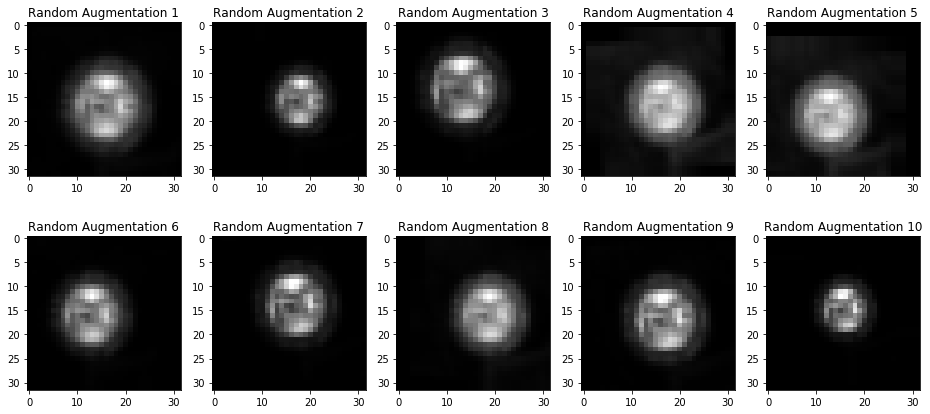

In [15]:
def AugmentingImage(image_batch, min_gamma, max_gamma, rotation, min_scale, max_scale, x_translation, y_translation):
    
    image_batch = AugmentingImageUsingGamma(image_batch, min_gamma, max_gamma)
    image_batch = AugmentingImageUsingRotation(image_batch, rotation)
    image_batch = AugmentingImageUsingScale(image_batch, min_scale, max_scale)
    image_batch = AugmentingImageUsingTranslation(image_batch, x_translation, y_translation)

    return image_batch

showImageCount = 10
index = 0
pltColCount = 5
loopPerRow = 5
target = 5
x_augmentation = x_grayscale_display[y_display == target]
x_augmentation = x_augmentation[0:1]
x_augmentation = np.tile(x_augmentation,(showImageCount,1,1,1))
x_augmentation = AugmentingImage(x_augmentation, 0.5, 2, 10, 0.7, 1.1, 3, 3)
fig = plt.figure(figsize=(16, 18 * showImageCount / loopPerRow / pltColCount))
for i in range(0, showImageCount):
    fig.add_subplot(showImageCount // loopPerRow, pltColCount, i * pltColCount // loopPerRow + 1)
    plt.imshow(x_augmentation[i,:,:,0], cmap='gray')
    plt.title('Random Augmentation {}'.format(i + 1))
plt.show()

### Preprocess all the images using stage 1 first

In [16]:
x_train_grayscale = convert_to_grayscale(x_train)
x_valid_grayscale = convert_to_grayscale(x_valid)
x_test_grayscale = convert_to_grayscale(x_test)

### Model Architecture

In [17]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

# TrafficSignClassifier
# Input: (32, 32, 1)
# Output: (43)
# Parameter: 5377643
def TrafficSignClassifier(x, init_mean, init_sigma, dropout_keep_prob):
    #Input Layer (32 x 32 x 1 Grayscale Image)
    
    # Convolution Layer with 64 3 x 3 kernel without padding and relu activation
    # Input: (32, 32, 1)
    # Output: (30, 30, 64)
    # Parameter: 576
    x = tf.nn.conv2d(x,
                     tf.Variable(tf.truncated_normal((3, 3, 1, 64),
                                                     mean = init_mean, stddev = init_sigma)),
                     [1, 1, 1, 1], 'VALID',
                     name='con2d_1')
    x = tf.nn.bias_add(x,
                       tf.Variable(tf.zeros(64)),
                       name='con2d_1_bias')
    x = tf.nn.relu(x, name='con2d_1_relu')
    
    # Convolution Layer with 64 3 x 3 kernel without padding and relu activation
    # Input: (30, 30, 64)
    # Output: (28, 28, 64)
    # Parameter: 36864
    x = tf.nn.conv2d(x,
                     tf.Variable(tf.truncated_normal((3, 3, 64, 64),
                                                     mean = init_mean, stddev = init_sigma)),
                     [1, 1, 1, 1], 'VALID',
                     name='con2d_2')
    x = tf.nn.bias_add(x,
                       tf.Variable(tf.zeros(64)),
                       name='con2d_2_bias')
    x = tf.nn.relu(x, name='con2d_2_relu')
    
    # Flatten Layer with 2 x 2 stride
    # Input: (28, 28, 64)
    # Output: (14, 14, 128)
    # Parameter: 0
    x = tf.nn.max_pool(x,
                       [1, 2, 2, 1],
                       [1, 2, 2, 1],
                       'SAME',
                       name='max_pool_1')
    
    # Convolution Layer with 128 3 x 3 kernel without padding and relu activation
    # Input: (14, 14, 64)
    # Output: (12, 12, 128)
    # Parameter: 73728
    x = tf.nn.conv2d(x,
                     tf.Variable(tf.truncated_normal((3, 3, 64, 128),
                                                     mean = init_mean, stddev = init_sigma)),
                     [1, 1, 1, 1], 'VALID',
                     name='con2d_2')
    x = tf.nn.bias_add(x,
                       tf.Variable(tf.zeros(128)),
                       name='con2d_2_bias')
    x = tf.nn.relu(x, name='con2d_3_relu')
    
    # Flatten Layer with 2 x 2 stride
    # Input: (12, 12, 128)
    # Output: (6, 6, 128)
    # Parameter: 0
    x = tf.nn.max_pool(x,
                      [1, 2, 2, 1],
                      [1, 2, 2, 1],
                      'SAME',
                       name='max_pool_2')
    
    # Flatten Layer
    # Input: (6, 6, 128)
    # Output: 4608
    # Parameter: 0
    x = flatten(x)
    
    # Dense Layer with relu activation
    # Input: 4608
    # Output: 1024
    # Parameter: 4719616
    x = tf.matmul(x,
                  tf.Variable(tf.truncated_normal((4608, 1024),
                                                  mean = init_mean, stddev = init_sigma)),
                  name='dense_1_matmul')
    x = tf.nn.bias_add(x,
                       tf.Variable(tf.zeros(1024)),
                       name='dense_1_bias')
    x = tf.nn.relu(x, name='dense_1_relu')
    
    # Dropout Layer
    x = tf.nn.dropout(x, keep_prob=dropout_keep_prob,
                     name='dense_1_dropout')
    
    # Dense Layer with relu activation
    # Output: 1024
    # Output: 512
    # Parameter: 524800
    x = tf.matmul(x,
                  tf.Variable(tf.truncated_normal((1024, 512),
                                                  mean = init_mean, stddev = init_sigma)),
                  name='dense_2_matmul')
    x = tf.nn.bias_add(x,
                       tf.Variable(tf.zeros(512)),
                       name='dense_2_bias')
    x = tf.nn.relu(x, name='dense_2_relu')
    
    # Dropout Layer
    x = tf.nn.dropout(x, keep_prob=dropout_keep_prob,
                     name='dense_2_dropout')
    
    
    # Dense Layer with relu activation
    # Output: 512
    # Output: 43
    # Parameter: 22059
    x = tf.matmul(x,
                  tf.Variable(tf.truncated_normal((512, 43),
                                                  mean = init_mean, stddev = init_sigma)),
                  name='dense_3_matmul')
    x = tf.nn.bias_add(x,
                       tf.Variable(tf.zeros(43)),
                       name='dense_3_bias')
    
    return x
    

In [18]:
x_holder = tf.placeholder(tf.float32, (None, 32, 32, 1))
y_holder = tf.placeholder(tf.int32, (None))
adam_learn_rate_holder = tf.placeholder(tf.float32, ())
dropout_keep_prob_holder = tf.placeholder_with_default(1.0, shape=())
one_hot_y = tf.one_hot(y_holder, 43)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [19]:
init_mean = 0
init_sigma = 0.1

logits = TrafficSignClassifier(x_holder, init_mean, init_sigma, dropout_keep_prob_holder)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = adam_learn_rate_holder)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
prediction = tf.argmax(logits, 1)

In [20]:
def compute(X_data, batch_size):
    num_examples = len(X_data)
    X_data = normalize(X_data)
    totalResult = np.array([])
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x = X_data[offset:offset + batch_size]
        result = sess.run(prediction, feed_dict={x_holder: batch_x})
        totalResult = np.concatenate((totalResult, result))
    return totalResult

def evaluate(X_data, y_data, batch_size):
    num_examples = len(X_data)
    X_data = normalize(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset + batch_size], y_data[offset:offset + batch_size]
        accuracy = sess.run(accuracy_operation, feed_dict={x_holder: batch_x, y_holder: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy * 100 / num_examples

In [23]:
min_gamma = 0.5
max_gamma = 2.0
max_rotation = 5.0
min_scale = 0.7
max_scale = 1.2
max_x_translation = 3
max_y_translation = 3


saver = tf.train.Saver()
def trainTrafficSignClassifier(x_train, y_train, x_valid, y_valid, x_test, y_test,
          epoch, learn_rate, batch_size, dropout_keep_prob, output_file):
    train_hist = []
    valid_hist = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        [x_temp, y_temp] = balanceAndShuffleData(x_train, y_train, n_classes)
        train_acc = evaluate(x_temp, y_temp, batch_size)
        valid_acc = evaluate(x_valid, y_valid, batch_size)
        train_hist.append(train_acc)
        valid_hist.append(valid_acc)
        num_examples = len(x_temp)
        print('case: {}'.format(num_examples))
        print('Epoch: {} / {} Training Accuracy: {:.3f}% Validation Accuracy = {:.3f}%'.format(0, epoch, train_acc, valid_acc))

        for i in range(epoch):
            [x_temp, y_temp] = balanceAndShuffleData(x_train, y_train, n_classes)
            x_temp = AugmentingImage(x_temp,
                                     min_gamma, max_gamma,
                                     max_rotation,
                                     min_scale, max_scale,
                                     max_x_translation, max_y_translation)
            for offset in range(0, num_examples, batch_size):
                end = offset + batch_size
                batch_x, batch_y = x_temp[offset:end], y_temp[offset:end]
                sess.run(training_operation, feed_dict={x_holder: batch_x,
                                                        y_holder: batch_y,
                                                        adam_learn_rate_holder: learn_rate,
                                                        dropout_keep_prob_holder: dropout_keep_prob})
            train_acc = evaluate(x_temp, y_temp, batch_size)
            valid_acc = evaluate(x_valid, y_valid, batch_size)

            train_hist.append(train_acc)
            valid_hist.append(valid_acc)
            print('Epoch: {} / {} Training Accuracy: {:.3f}% Validation Accuracy = {:.3f}%'.format(i + 1, epoch, train_acc, valid_acc))

        saver.save(sess, output_file)

        test_acc = evaluate(x_test, y_test, batch_size)
        print('Test Accuracy = {:.3f}%'.format(test_acc))

        y_train_result = compute(x_train, batch_size)
        y_valid_result = compute(x_valid, batch_size)
        y_test_result = compute(x_test, batch_size)
        print('Model saved')
    return y_train_result, y_valid_result, y_test_result, test_acc, train_hist, valid_hist

In [ ]:
epoch = 10
learn_rate = 0.001
batch_size = 512
dropout_keep_prob = 0.8
output_file = './trafficSignClassifier08DropFull'

y_train_result1, y_valid_result1, y_test_result1, test_acc1, train_hist1, valid_hist1 = trainTrafficSignClassifier(
    x_train_grayscale, y_train, x_valid_grayscale, y_valid, x_test_grayscale, y_test,
    epoch, learn_rate, batch_size, dropout_keep_prob, output_file)

epoch = 10
learn_rate = 0.001
batch_size = 512
dropout_keep_prob = 1.0
output_file = './trafficSignClassifier10DropFull'

y_train_result2, y_valid_result2, y_test_result2, test_acc2, train_hist2, valid_hist2 = trainTrafficSignClassifier(
    x_train_grayscale, y_train, x_valid_grayscale, y_valid, x_test_grayscale, y_test,
    epoch, learn_rate, batch_size, dropout_keep_prob, output_file)

case: 86430
Epoch: 0 / 10 Training Accuracy: 3.491% Validation Accuracy = 2.653%


In [ ]:
epoch = 10
learn_rate = 0.001
batch_size = 256
dropout_keep_prob = 1.0
output_file = './trafficSignClassifier08DropFull'

y_train_result3, y_valid_result3, y_test_result3, test_acc3, train_hist3, valid_hist3 = trainTrafficSignClassifier(
    x_train_grayscale, y_train, x_valid_grayscale, y_valid, x_test_grayscale, y_test,
    epoch, learn_rate, batch_size, dropout_keep_prob, output_file)

In [ ]:
epoch = 10
learn_rate = 0.001
batch_size = 512
dropout_keep_prob = 1.0
output_file = './trafficSignClassifier10DropFull'

y_train_result4, y_valid_result4, y_test_result4, test_acc4, train_hist4, valid_hist4 = trainTrafficSignClassifier(
    x_train_grayscale, y_train, x_valid_grayscale, y_valid, x_test_grayscale, y_test,
    epoch, learn_rate, batch_size, dropout_keep_prob, output_file)

In [ ]:
plt.figure(figsize=(16,4))

fig.add_subplot(1, 4, 1)
plt.plot(train_hist1)
plt.plot(valid_hist1)
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'Validate'], loc='right')

fig.add_subplot(1, 4, 2)
plt.plot(train_hist2)
plt.plot(valid_hist2)
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'Validate'], loc='right')

fig.add_subplot(1, 4, 3)
plt.plot(train_hist)
plt.plot(valid_hist)
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'Validate'], loc='right')

fig.add_subplot(1, 4, 4)
plt.plot(train_hist)
plt.plot(valid_hist)
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'Validate'], loc='right')
plt.show()

In [ ]:
def showWrongResult(x, y, y_result, max_show_count = 20):
    wrong = np.zeros_like(y)
    wrong[y_result != y] = 1
    wrong_count = np.sum(wrong)
    print(wrong_count)

    if wrong_count > max_show_count:
        wrong_count = max_show_count

    showImageCount = wrong_count
    index = 0
    pltColCount = 5
    loopPerRow = 5
    target = 1
    x_image = x[y_result != y]
    y_ground_truth = y[y_result != y]
    y_prediction = y_result[y_result != y]
    fig = plt.figure(figsize=(16, 18 * showImageCount / loopPerRow / pltColCount))
    for i in range(0, showImageCount):
        temp = 1
        fig.add_subplot(showImageCount // loopPerRow, pltColCount, i * pltColCount // loopPerRow + temp)
        plt.imshow(x_image[i])
        plt.title('Label {} \n Prediction {}'.format(sign_names[y_ground_truth[i]], sign_names[int(y_prediction[i])]))

    plt.show()



In [ ]:
showWrongResult(x_train, y_train, y_train_result, 10)

In [ ]:
showWrongResult(x_valid, y_valid, y_valid_result, 10)

In [ ]:
showWrongResult(x_test, y_test, y_test_result, 10)

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")